In [1]:
import time
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization, Input, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split as tts
import tensorflow as tf
# imports for cpu use
import random
import sys
from tensorflow.python.client import device_lib

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
DIR_TEST = 'D:/cours/quatrième année/Deep learning/Projet kaggle/nybg2020/test/'
DIR_TRAIN = 'D:/cours/quatrième année/Deep learning/Projet kaggle/nybg2020/train/'
META_DATA_TRAIN = DIR_TRAIN+'metadata.json'
META_DATA_TEST = DIR_TEST+'metadata.json'

In [3]:
#CHECK HOW MANY GPU ON PC
# Check if the server/ instance is having GPU/ CPU from python code
import sys
import tensorflow as tf
from tensorflow.python.client import device_lib

# device_lib.list_local_devices()     ## this command list all the processing device GPU and CPU

print("all devices\n", device_lib.list_local_devices(), '\n')
device_name = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
if device_name[0] == "/device:GPU:0":
    device_name = "/gpu:0"
    print('GPU')
else:
    print('CPU')

print("Utiliser son cpu en utilisant des with tf.device('/cpu:0'):")


all devices
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10103619115100896589
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3144653209
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2008283492221974167
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
] 

GPU
Utiliser son cpu en utilisant des with tf.device('/cpu:0'):


In [4]:
'''
TRAIN_PATH = 'D:/cours/quatrième année/Deep learning/Projet kaggle/nybg2020/train_separated/'
cnt = 0
for category in os.listdir(TRAIN_PATH):
    if len(os.listdir(TRAIN_PATH+category)) < 10:
        cnt += 1
        open_dir = (os.listdir(TRAIN_PATH+category))
        print(category)
        for image in open_dir:
            try:
                img = read_img(TRAIN_PATH+str(category)+'/'+image)
                x = img_to_array(img)
                x = x.reshape((1,) + x.shape)
                i = 0
                for batch in image_gen.flow(x, batch_size=1, save_to_dir=TRAIN_PATH+str(category)+'/', save_prefix='datagen', save_format="jpg"):
                    i+=1
                    if i > 10:
                        break
            except Exception as e:
                print("image caused error => " % image)
                break
print("Nombre de categroies avec moins 10 images %s" % (cnt))
'''

'\nTRAIN_PATH = \'D:/cours/quatrième année/Deep learning/Projet kaggle/nybg2020/train_separated/\'\ncnt = 0\nfor category in os.listdir(TRAIN_PATH):\n    if len(os.listdir(TRAIN_PATH+category)) < 10:\n        cnt += 1\n        open_dir = (os.listdir(TRAIN_PATH+category))\n        print(category)\n        for image in open_dir:\n            try:\n                img = read_img(TRAIN_PATH+str(category)+\'/\'+image)\n                x = img_to_array(img)\n                x = x.reshape((1,) + x.shape)\n                i = 0\n                for batch in image_gen.flow(x, batch_size=1, save_to_dir=TRAIN_PATH+str(category)+\'/\', save_prefix=\'datagen\', save_format="jpg"):\n                    i+=1\n                    if i > 10:\n                        break\n            except Exception as e:\n                print("image caused error => " % image)\n                break\nprint("Nombre de categroies avec moins 10 images %s" % (cnt))\n'

In [5]:
start_time = time.time()

In [6]:
with tf.device("/cpu:0"):
    with open(META_DATA_TRAIN, 'r') as json_file:
        data_train = json.load(json_file)
        for key in data_train:
            print("-",key, len(data_train[key]))
    print("================================")
    with open(META_DATA_TEST, 'r') as json_file2:
        data_test = json.load(json_file2)
        for key in data_test:
            print("-",key, len(data_test[key]))

- annotations 1030747
- categories 32094
- images 1030747
- info 6
- licenses 1
- regions 4
- images 138292
- info 6
- licenses 1


# ============= TESTS THEORIE MINI APPRENTISSAGE ============== #

### ================================== COLLECT TRAIN DATA ================================== ###

In [7]:
with tf.device("/cpu:0"):
    df_images = pd.DataFrame(data_train['images'])
    display(df_images.head(3))
    df_categories = pd.DataFrame(data_train['categories'])
    df_annotations = pd.DataFrame(data_train['annotations'])
    assert len(df_annotations) == len(df_images)
    df_images_annotations = pd.merge(df_images, df_annotations, left_on='id', right_on='image_id', how='right').drop('image_id', axis=1)
    df_images_annotations = df_images_annotations.sort_values(['category_id'])

,file_name,height,id,license,width
0,images/156/72/354106.jpg,1000,354106,1,661
1,images/115/24/818566.jpg,1000,818566,1,661
2,images/115/24/750704.jpg,1000,750704,1,661


In [8]:
with tf.device("/cpu:0"):
    df_families = df_categories.drop('genus', axis=1).drop('id', axis=1).drop('name', axis=1).drop_duplicates().reset_index().drop('index', axis=1)
    df_families.head(3)

In [9]:
with tf.device("/cpu:0"):
    df_images_infos = pd.merge(df_images_annotations, df_categories, left_on='category_id', right_on='id', how='right')\
                        .drop('height', axis=1).drop('id_x', axis=1).drop('license', axis=1).drop('width', axis=1)\
                        .drop('category_id', axis=1).drop('id_y', axis=1).drop('region_id', axis=1).drop('name', axis=1)

    df_images_infos = df_images_infos.rename(columns={"id":"category_id"})

    df_images_infos.sort_values(by='family', ascending=False)

### ================================== COLLECT TEST DATA ================================== ###

In [10]:
with tf.device("/cpu:0"):
    df_images = pd.DataFrame(data_test['images']).drop('height', axis=1).drop('width', axis=1).drop('license', axis=1)
    display(df_images.head(3))

,file_name,id
0,images/104/104891.jpg,104891
1,images/018/18029.jpg,18029
2,images/035/35151.jpg,35151


### ======================================= SAVE DATA ====================================== ###

In [11]:
with tf.device("/cpu:0"):
    df_images_infos.to_csv('D:/cours/quatrième année/Deep learning/Projet kaggle/full_train_data.csv', index=False)
    df_images.to_csv('D:/cours/quatrième année/Deep learning/Projet kaggle/full_test_data.csv', index=False)

### ===================================== EXPLORE DATA ==================================== ###

In [12]:
with tf.device("/cpu:0"):
    family_explo = df_images_infos[['family', 'genus', 'category_id']].groupby(['family', 'genus']).count()
    display(family_explo.describe())

,category_id
count,3680.000000
mean,280.094565
std,763.668945
min,2.000000
25%,12.000000
50%,54.000000
75%,198.000000
max,14490.000000


### ==================================== MODEL CREATION =================================== ###

In [13]:
with tf.device("/cpu:0"):
    in_out_size = (64*64) + 3
    img_shape = 64
    name_of_model = "cnn_1_softmax_family_02"
    def xavier(shape, dtype=None):
        return np.random.rand(*shape)*np.sqrt(1/in_out_size)

In [14]:
with tf.device("/cpu:0"):
    def fg_model(shape, lr=0.001):
        '''Family-Genus model receives an image and outputs two integers indicating both the family and genus index.'''
        i = Input(shape)
        
        #MLP
        #x = Flatten()(i)
            
        #x = Dense(1024, activation='relu', name='dense_1', kernel_initializer=xavier)(x)
        #x = Dense(512, activation='relu', name='dense_2', kernel_initializer=xavier)(x)
        #x = Dense(256, activation='relu', name='dense_3', kernel_initializer=xavier)(x)
        
        '''
        #CNN NEAR KAGGLE 
        x = Conv2D(3, (3, 3), activation='relu', padding='same', kernel_initializer=xavier)(i)
        x = Conv2D(3, (3, 3), activation='relu', padding='same', kernel_initializer=xavier)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.5)(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer=xavier)(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_initializer=xavier)(x)
        x = MaxPool2D(pool_size=(2, 2))(x)
        #x = BatchNormalization()(x)
        #x = Dropout(0.5)(x)
        x = Flatten()(x)
        '''
        
        #CNN POWERFULL
        x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=xavier, padding='same')(i)
        x = BatchNormalization()(x)
        x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=xavier, padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D((2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=xavier, padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=xavier, padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D((2, 2))(x)
        x = Dropout(0.25)(x)
        x = Conv2D(128, (3, 3), activation='relu', kernel_initializer=xavier, padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(128, (3, 3), activation='relu', kernel_initializer=xavier, padding='same')(x)
        x = BatchNormalization()(x)
        x = MaxPool2D((2, 2))(x)
        x = Dropout(0.25)(x)
        x = Flatten()(x)
        x = Dense(128, activation='relu', kernel_initializer=xavier)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)
            
        
        o1 = Dense(310, activation='softmax', name='family', kernel_initializer=xavier)(x)

        #o2 = concatenate([o1, x])
        #o2 = Dense(3678, activation='softmax', name='genus', kernel_initializer=xavier)(o2)

        #o3 = concatenate([o1, o2, x])
        #o3 = Dense(32094, activation='softmax', name='category_id', kernel_initializer=xavier)(x)

        x = Model(inputs=i, outputs=o1)

        opt = Adam(lr=lr, amsgrad=True)
        x.compile(optimizer=opt, loss=['sparse_categorical_crossentropy'],
                     metrics=['accuracy'])
        return x

    model = fg_model((img_shape, img_shape, 3))
    model.summary()
    #plot_model(model, to_file='full_model_plot.png', show_shapes=True, show_layer_names=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0     

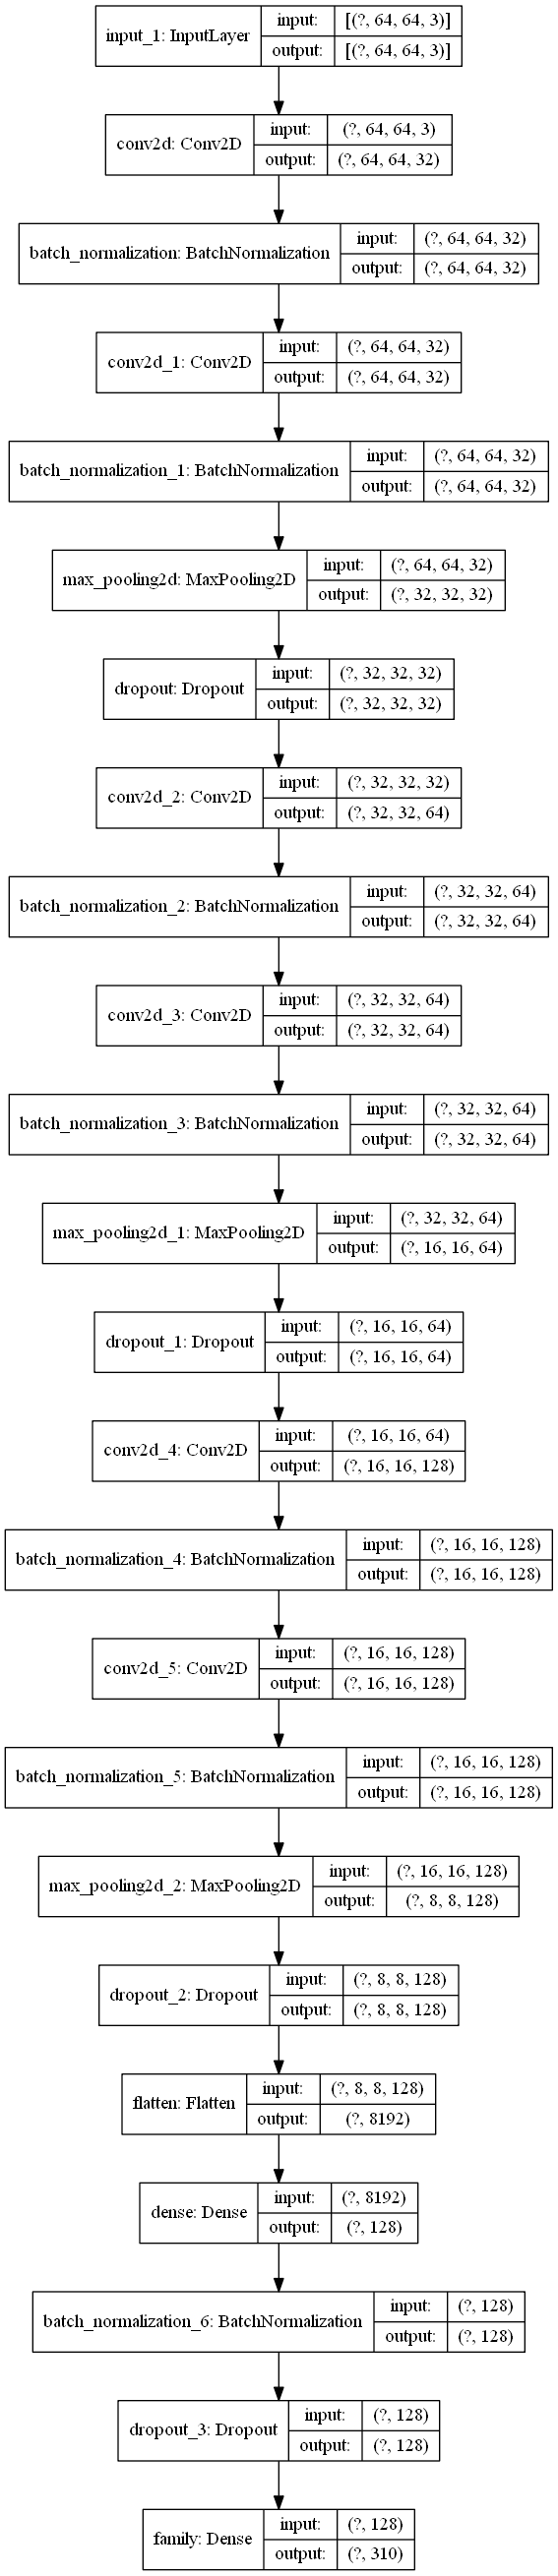

In [15]:
plot_model(model, to_file=name_of_model + '_model_plot.png', show_shapes=True, show_layer_names=True)

### ==================================== DATA GENERATOR =================================== ###

In [16]:
with tf.device("/cpu:0"):
    train_datagen = ImageDataGenerator(featurewise_center=False,
                                         featurewise_std_normalization=False,
                                         rotation_range=180,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         zoom_range=0.2)

In [17]:
with tf.device("/cpu:0"):
    m = df_images_infos[['file_name', 'family', 'genus', 'category_id']]
    fam = m.family.unique().tolist()
    m.family = m.family.map(lambda x: fam.index(x))
    gen = m.genus.unique().tolist()
    m.genus = m.genus.map(lambda x: gen.index(x))
    display(m)
    print("KILL THE NAN VALUE IN M TO PREVENT BUGS")
    print(type(m))
    na = m.file_name.isna()
    keep = [x for x in range(m.shape[0]) if not na[x]]
    m = m.iloc[keep]

,file_name,family,genus,category_id
0,images/000/00/626762.jpg,0,0,0
1,images/000/00/72077.jpg,0,0,0
2,images/000/00/818271.jpg,0,0,0
3,images/000/00/495523.jpg,0,0,0
4,images/000/00/437000.jpg,0,0,0
...,...,...,...,...
1030743,images/320/93/946506.jpg,41,3677,32093
1030744,images/320/93/1010199.jpg,41,3677,32093
1030745,images/320/93/35450.jpg,41,3677,32093
1030746,images/320/93/68259.jpg,41,3677,32093


KILL THE NAN VALUE IN M TO PREVENT BUGS
<class 'pandas.core.frame.DataFrame'>


In [18]:
# get list of category for each family
family_to_category = []
uniq_fam = m["family"].unique()

for fam in uniq_fam:
    m_fam = m[m["family"] == fam]
    m_fam = m_fam["category_id"].unique()
    #print(m_fam)
    #print(m_fam.tolist())
    family_to_category.append(m_fam.tolist())
    
    #print(m_fam)

print("test\n",family_to_category[309])

test
 [31940, 31941, 31942, 31943, 31944, 31945, 31946, 31947]


In [19]:
'''
train = train[:400000]
verif = verif[:100000]
verif.head(5)
store_type = verif.dtypes
print("before ver ", store_type)
verif = verif.astype(str)
print("after ver ", verif.dtypes)

store_type_2 = train.dtypes
print("before train ", store_type_2)
train = train.astype(str)
print("after train ", train.dtypes)

print("train x_col type = ", type(train['file_name'].values[0]))
print("test x_col type = ", type(verif['file_name'].values[0]))
'''

'\ntrain = train[:400000]\nverif = verif[:100000]\nverif.head(5)\nstore_type = verif.dtypes\nprint("before ver ", store_type)\nverif = verif.astype(str)\nprint("after ver ", verif.dtypes)\n\nstore_type_2 = train.dtypes\nprint("before train ", store_type_2)\ntrain = train.astype(str)\nprint("after train ", train.dtypes)\n\nprint("train x_col type = ", type(train[\'file_name\'].values[0]))\nprint("test x_col type = ", type(verif[\'file_name\'].values[0]))\n'

### ========================================= TRAIN ======================================== ###

In [20]:
#hyperparams
with tf.device("/cpu:0"):
    train, verif = tts(m, test_size=0.2, shuffle=True)#,random_state=17)
    train = train[:16000]
    verif = verif[:4000]
    shape = (img_shape, img_shape, 3)
    epochs = 50
    batch_size = 640
    old_model = 0

In [21]:
with tf.device("/cpu:0"):
#     train, verif = tts(m, test_size=0.2, shuffle=True)#,random_state=17)
#     train = train[:16000]
#     verif = verif[:4000]
#     shape = (img_shape, img_shape, 3)
#     epochs = 3
#     batch_size = 640

    print("TYPE",type(train['category_id']))

    # cast in str to try avoiding bug
    #train['category_id'] = train['category_id'].astype(str)
    #verif['category_id'] = verif['category_id'].astype(str)

    print("after train \n", train.dtypes)
    print("\nfile name = ", type(train['file_name']))

    model = fg_model(shape, 0.007)
    
    # If you want to train further an old model
    if old_model != 0:
        model = tf.keras.models.load_model(name_of_model+'_fg_model.h5', custom_objects={"xavier":xavier})
        name_of_model = name_of_model + "_2eme_iter"

    #Disable the last two output layers for training the Family
    for layers in model.layers:
        if layers.name == 'genus' or layers.name=='category_id':
            layers.trainable = False        


    # number of distinct families in train and test
    print("Nombre de catégories entrainées dans train",train['family'].nunique())
    print("Nombre de catégories entrainées dans verif",verif['family'].nunique())

    #Make the family layer Trainable
    for layers in model.layers:
        if layers.name == 'family':
            layers.trainable = True

    model.fit_generator(train_datagen.flow_from_dataframe(dataframe=train,
                                                          directory=DIR_TRAIN,
                                                          x_col="file_name",
                                                          y_col="family",
                                                          target_size=(img_shape, img_shape),
                                                          batch_size=batch_size,
                                                          class_mode='raw'),
                        validation_data=train_datagen.flow_from_dataframe(
                            dataframe=verif,
                            directory=DIR_TRAIN,
                            x_col="file_name",
                            y_col="family",
                            target_size=(img_shape, img_shape),
                            batch_size=batch_size,
                            class_mode='raw'),
                        epochs=epochs,
                        steps_per_epoch=len(train)//batch_size,
                        validation_steps=len(verif)//batch_size,
                        verbose=1,
                        workers=8,
                        use_multiprocessing=False)


    # #Reshuffle the inputs
    # train, verif = tts(m, test_size=0.2, shuffle=True, random_state=17)
    # train = train[:400000]
    # verif = verif[:100000]

    # #Make the Genus layer Trainable
    # for layers in model.layers:
    #     if layers.name == 'genus':
    #         layers.trainable = True

    # #Train Family and Genus for 2 epochs
    # model.fit_generator(train_datagen.flow_from_dataframe(dataframe=train,
    #                                                       directory=DIR_TRAIN,
    #                                                       x_col="file_name",
    #                                                       y_col=["family", "genus", "category_id"],
    #                                                       target_size=(img_shape, img_shape),
    #                                                       batch_size=batch_size,
    #                                                       class_mode='multi_output'),
    #                     validation_data=train_datagen.flow_from_dataframe(
    #                         dataframe=verif,
    #                         directory=DIR_TRAIN,
    #                         x_col="file_name",
    #                         y_col=["family", "genus", "category_id"],
    #                         target_size=(img_shape, img_shape),
    #                         batch_size=batch_size,
    #                         class_mode='multi_output'),
    #                     epochs=epochs,
    #                     steps_per_epoch=len(train)//batch_size,
    #                     validation_steps=len(verif)//batch_size,
    #                     verbose=1,
    #                     workers=8,
    #                     use_multiprocessing=False)

    # #Reshuffle the inputs
    # train, verif = tts(m, test_size=0.2, shuffle=True, random_state=17)
    # train = train[:400000]
    # verif = verif[:100000]

    # #Make the category_id layer Trainable
    # for layers in model.layers:
    #     if layers.name == 'category_id':
    #         layers.trainable = True

    # #Train them all for 2 epochs
    # model.fit_generator(train_datagen.flow_from_dataframe(dataframe=train,
    #                                                       directory=DIR_TRAIN,
    #                                                       x_col="file_name",
    #                                                       y_col=["family", "genus", "category_id"],
    #                                                       target_size=(img_shape, img_shape),
    #                                                       batch_size=batch_size,
    #                                                       class_mode='multi_output'),
    #                     validation_data=train_datagen.flow_from_dataframe(
    #                         dataframe=verif,
    #                         directory=DIR_TRAIN,
    #                         x_col="file_name",
    #                         y_col=["family", "genus", "category_id"],
    #                         target_size=(img_shape, img_shape),
    #                         batch_size=batch_size,
    #                         class_mode='multi_output'),
    #                     epochs=epochs,
    #                     steps_per_epoch=len(train)//batch_size,
    #                     validation_steps=len(verif)//batch_size,
    #                     verbose=1,
    #                     workers=8,
    #                     use_multiprocessing=False)

TYPE <class 'pandas.core.series.Series'>
after train 
 file_name      object
family          int64
genus           int64
category_id     int64
dtype: object

file name =  <class 'pandas.core.series.Series'>
Nombre de catégories entrainées dans train 259
Nombre de catégories entrainées dans verif 213
Found 16000 validated image filenames.
Found 4000 validated image filenames.
Epoch 1/50
25/25 [==============================] - 627s 25s/step - loss: 5.3266 - accuracy: 0.0718 - val_loss: 15.1443 - val_accuracy: 0.0604
Epoch 2/50
25/25 [==============================] - 572s 23s/step - loss: 4.4592 - accuracy: 0.1112 - val_loss: 15.5926 - val_accuracy: 0.0310
Epoch 3/50
25/25 [==============================] - 564s 23s/step - loss: 4.2200 - accuracy: 0.1181 - val_loss: 16.1139 - val_accuracy: 2.6042e-04
Epoch 4/50
25/25 [==============================] - 498s 20s/step - loss: 4.1714 - accuracy: 0.1243 - val_loss: 16.1166 - val_accuracy: 0.0000e+00
Epoch 5/50
25/25 [========================

In [22]:
model.save(name_of_model + '_fg_model.h5')

### ======================================== PREDICT ======================================= ###

In [23]:
with tf.device("/cpu:0"):
    batch_size = 640
    train_model = tf.keras.models.load_model(name_of_model+'_fg_model.h5', custom_objects={"xavier":xavier})

    test_datagen = ImageDataGenerator(featurewise_center=False,
                                      featurewise_std_normalization=False)

    generator = test_datagen.flow_from_dataframe(
            dataframe = df_images,#.iloc[:50000], #Limiting the test to the first 50,000 items
            directory = DIR_TEST,
            x_col = 'file_name',
            target_size=(img_shape, img_shape),
            batch_size=batch_size,
            class_mode=None,  # only data, no labels
            shuffle=False)

    family = train_model.predict_generator(generator, verbose=1) #category before

Found 138292 validated image filenames.
217/217 [==============================] - 2544s 12s/step


### ====================================== SUBMISSION ====================================== ###

In [24]:
# get list of category for each family

In [25]:
sub = pd.DataFrame()
sub['Id'] = df_images.id
sub['Id'] = sub['Id'].astype('int32')

print(family.shape)
sub['Predicted'] = np.concatenate([np.argmax(family, axis=1), 23718*np.ones((len(df_images.id)-len(family)))], axis=0)
sub['Predicted'] = sub['Predicted'].astype('int32')
display(sub)


# for sub in sub['Predicted']:
#     print(sub)


#now that we have family, we are gonna generate a random category for each row (according to family)
def random_catego(x):
    x = random.choice(family_to_category[x])
    return x

sub['Predicted'] = sub['Predicted'].apply(random_catego)

# old basic random 
# sub['Predicted'] = list(map(int, np.random.randint(1, 32094, (df_images.shape[0]))))

sub.to_csv(name_of_model+'_category_submission.csv', index=False)
print("nombres de classes différentes prédites :", sub['Predicted'].nunique())

(138292, 310)


,Id,Predicted
0,104891,99
1,18029,1
2,35151,26
3,124144,0
4,24649,9
...,...,...
138287,32738,79
138288,16804,10
138289,113662,91
138290,86100,96


nombres de classes différentes prédites : 18911


In [26]:
# sub = pd.DataFrame()
# sub['Id'] = df_images.id
# sub['Id'] = sub['Id'].astype('int32')

# sub['Predicted'] = np.concatenate([np.argmax(category, axis=1), 23718*np.ones((len(df_images.id)-len(category)))], axis=0)
# sub['Predicted'] = sub['Predicted'].astype('int32')

# display(sub)
# sub.to_csv(name_of_model+'_category_submission.csv', index=False)
# print("nombres de classes différentes prédites :", sub['Predicted'].nunique())

# # #random predict
# # with tf.device("/cpu:0"):
# #     sub = pd.DataFrame()
# #     sub['Id'] = df_images.id
# #     sub['Predicted'] = list(map(int, np.random.randint(1, 32094, (df_images.shape[0]))))

# #     sub.to_csv('random_submission.csv', index=False)
# #     print("nombres de classes différentes prédites :", sub['Predicted'].nunique())

In [27]:
# sub['Predicted'] = np.concatenate([np.argmax(family, axis=1), np.zeros((len(df_images.id)-len(family)))], axis=0)
# sub['Predicted'] = sub['Predicted'].astype('int32')
# display(sub)
# sub.to_csv(name_of_model+'cnn_5_family_submission.csv', index=False)

In [28]:
# sub['Predicted'] = np.concatenate([np.argmax(genus, axis=1), np.zeros((len(df_images.id)-len(genus)))], axis=0)
# sub['Predicted'] = sub['Predicted'].astype('int32')
# display(sub)
# sub.to_csv(name_of_model+'_genus_submission.csv', index=False)

In [29]:
end_time = time.time()
total = end_time - start_time
h = total//3600
m = (total%3600)//60
s = total%60
print("Total time spent: %i hours, %i minutes, and %i seconds" %(h, m, s))

Total time spent: 7 hours, 12 minutes, and 36 seconds
